# 1 - Examine clusters within the dataset as a whole
### In future notebook iterations I will focus on clusters within specific citation sub-categories.

### IMPORT LIBRARIES AND DATA

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [3]:
df.shape

(38417, 9)

In [4]:
df.head()

,beat,cited_person_age,charge_description,street,month,day_of_week,hour_of_day,place_id,age_breaks
0,12.0,19.0,Speed Greater Than R&P or Posted,E Shea Bl,7,2,7,E Shea Bl - 6xxx,"(17.999, 24.0]"
1,12.0,36.0,Speed Greater Than R&P or Posted,E Shea Bl,7,2,8,E Shea Bl - 6xxx,"(29.0, 39.0]"
2,7.0,61.0,Speed Greater Than R&P or Posted,N Goldwater Bl,7,2,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
3,7.0,59.0,Speed Greater Than R&P or Posted,N Goldwater Bl,7,3,8,N Goldwater Bl - 4xxx,"(51.0, 97.0]"
4,19.0,23.0,Speed Greater Than R&P or Posted,N Pima Rd,7,5,22,N Pima Rd - 2xxx,"(17.999, 24.0]"


In [6]:
# drop features I don't want to use for this notebook iteration
df.drop(['place_id'], axis=1, inplace=True)
df.drop(['age_breaks'], axis=1, inplace=True)

In [10]:
# a high number of unique streets
# will create a lot of noise for clustering reasons
# instead of using street, I will use 'beat'
df.street.nunique()

1658

In [11]:
df.drop(['street'], axis=1, inplace=True)

In [12]:
df.head()

,beat,cited_person_age,charge_description,month,day_of_week,hour_of_day
0,12.0,19.0,Speed Greater Than R&P or Posted,7,2,7
1,12.0,36.0,Speed Greater Than R&P or Posted,7,2,8
2,7.0,61.0,Speed Greater Than R&P or Posted,7,2,8
3,7.0,59.0,Speed Greater Than R&P or Posted,7,3,8
4,19.0,23.0,Speed Greater Than R&P or Posted,7,5,22


### CLUSTER USING DBSCAN

In [13]:
X = pd.get_dummies(df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [14]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

MemoryError: 

In [15]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

,sil_score,cluster_count,eps,min_samples
8,0.457,30,1.0,5
9,0.438,14,1.0,10
10,0.375,17,1.0,25
12,0.305,10,5.0,5
13,0.305,9,5.0,10
14,0.305,7,5.0,25
15,0.305,7,5.0,50
11,0.281,15,1.0,50
7,-0.320,13,0.5,50
6,-0.328,29,0.5,25


## Iterations based on best parameters from above

### eps=1, min_sampels=5
Many of these clusters are very small

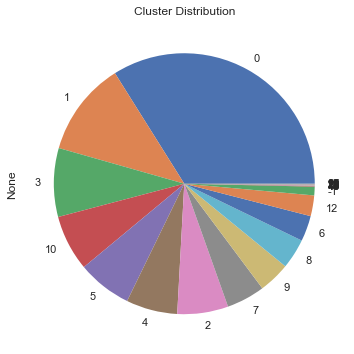

In [16]:
plt.figure(figsize=(6, 6))

dbscan_cluster = DBSCAN(eps=1, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [17]:
pd.Series(clusters).value_counts(dropna=False)

 0     13030
 1      4486
 3      3270
 10     2659
 5      2595
 4      2441
 2      2424
 7      1828
 9      1496
 8      1433
 6      1219
 12      985
-1       413
 19       23
 18       14
 17       13
 13       10
 16        7
 14        7
 11        7
 28        6
 21        6
 20        6
 15        6
 22        5
 23        5
 24        5
 25        5
 26        5
 27        4
 29        4
dtype: int64

### eps=1, min_sampels=10
This produced a relatively even clustering distribution.

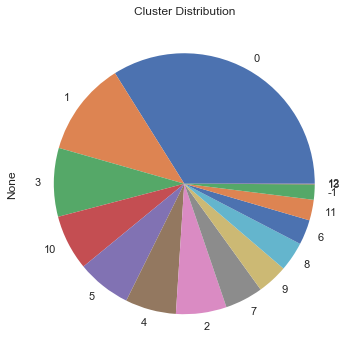

In [21]:
plt.figure(figsize=(6, 6))

dbscan_cluster = DBSCAN(eps=1, min_samples=10)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [22]:
pd.Series(clusters).value_counts(dropna=False)

 0     13028
 1      4481
 3      3268
 10     2635
 5      2585
 4      2421
 2      2407
 7      1810
 9      1456
 8      1398
 6      1188
 11      982
-1       731
 13       15
 12       12
dtype: int64

In [25]:
# format beat 6 data for plotting
df_clusters = pd.concat([df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

In [29]:
# exclude clusters that don't fit into another cluster
df_clusters = df_clusters[df_clusters.cluster != -1]

In [44]:
df_clusters.cluster.value_counts()

0     13028
1      4481
3      3268
10     2635
5      2585
4      2421
2      2407
7      1810
9      1456
8      1398
6      1188
11      982
13       15
12       12
Name: cluster, dtype: int64

In [49]:
df_clusters[df_clusters.cluster == 13]

,beat,cited_person_age,charge_description,month,day_of_week,hour_of_day,cluster
3019,99.0,31.0,Speed Greater Than R&P or Posted,4,0,13,13
8728,99.0,34.0,Speed Greater Than R&P or Posted,1,3,5,13
8903,99.0,26.0,Speed Greater Than R&P or Posted,5,0,12,13
11736,99.0,18.0,Speed Greater Than R&P or Posted,2,2,13,13
16069,99.0,25.0,Speed Greater Than R&P or Posted,2,1,10,13
17070,99.0,30.0,Speed Greater Than R&P or Posted,7,1,9,13
18640,99.0,33.0,Speed Greater Than R&P or Posted,3,3,7,13
24600,99.0,31.0,Speed Greater Than R&P or Posted,4,1,8,13
31937,99.0,35.0,Speed Greater Than R&P or Posted,2,2,6,13
31941,99.0,23.0,Speed Greater Than R&P or Posted,2,2,6,13


In [50]:
df_clusters[df_clusters.cluster == 12]

,beat,cited_person_age,charge_description,month,day_of_week,hour_of_day,cluster
15047,1.0,25.0,Fail to Stop at Stop Sign,10,5,1,12
15048,1.0,36.0,Fail to Stop at Stop Sign,10,6,0,12
18467,3.0,25.0,Fail to Stop at Stop Sign,11,6,2,12
19428,6.0,21.0,Fail to Stop at Stop Sign,11,5,0,12
20372,1.0,26.0,Fail to Stop at Stop Sign,11,5,0,12
24836,2.0,18.0,Fail to Stop at Stop Sign,9,5,1,12
26185,6.0,33.0,Fail to Stop at Stop Sign,12,6,3,12
26200,3.0,34.0,Fail to Stop at Stop Sign,12,6,0,12
27829,3.0,24.0,Fail to Stop at Stop Sign,9,5,1,12
32174,1.0,26.0,Fail to Stop at Stop Sign,10,5,1,12


In [32]:
# groupby results to examine why clusters where formed in the ways that they were
df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']]

,,cited_person_age
,,mean
cluster,charge_description,
0,Speed Greater Than R&P or Posted,38.425161
1,Expired/No Arizona Registration,36.869672
2,No Proof of Insurance,36.343166
3,Suspended/Revoked D.L.,34.443084
4,Drug Paraphernalia-Possess/Use,29.600991
5,Failure to Control Speed to Avoid A Collision,40.612379
6,Exceed Limit By More Than 20mph,32.362795
7,Fail to Obey Traffic Control Device,41.027072


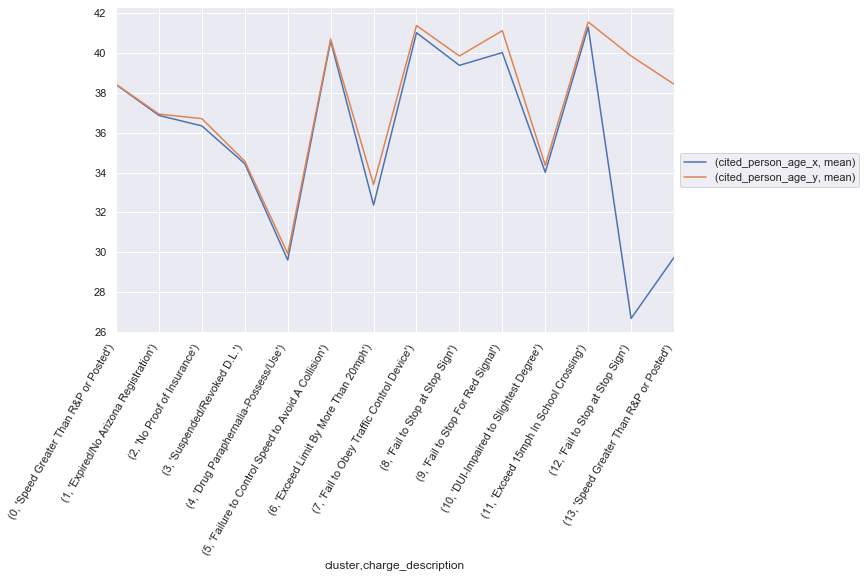

In [45]:
# fig, plt.subplots(figsize=(12, 6))

fig, ax = plt.subplots(figsize=(10, 6))

df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index(),
how='left',
on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))

ax.set_xticks(range(0, len(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['cited_person_age']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['cited_person_age']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=60, horizontalalignment="right");

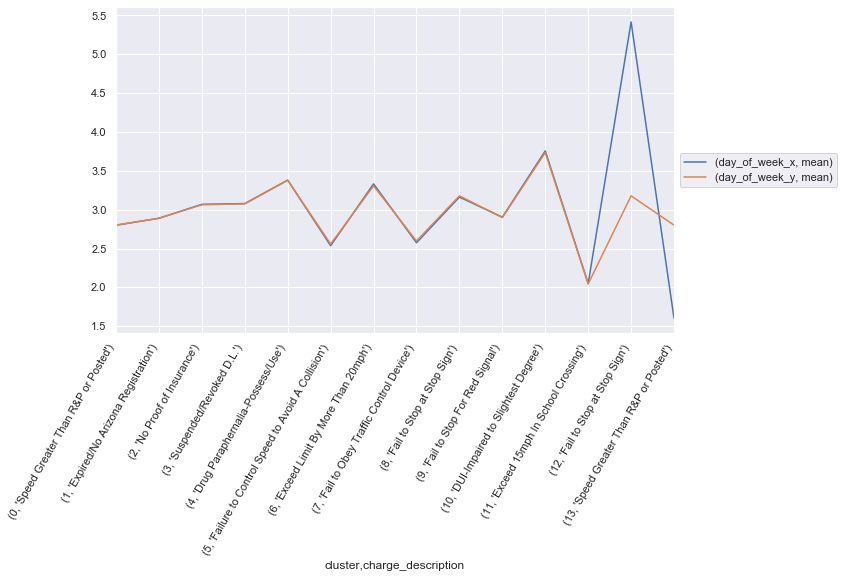

In [46]:
# fig, plt.subplots(figsize=(12, 6))

fig, ax = plt.subplots(figsize=(10, 6))

df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index(),
how='left',
on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))


ax.set_xticks(range(0, len(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['day_of_week']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['day_of_week']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=60, horizontalalignment="right");

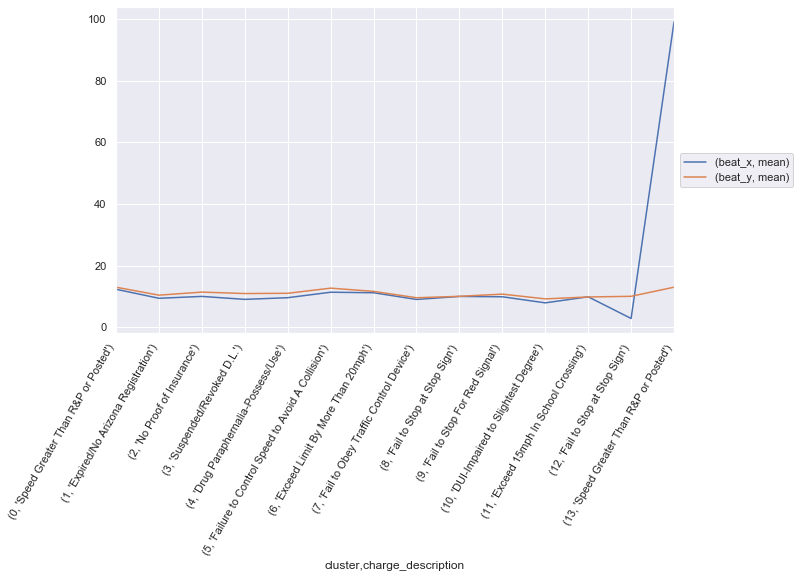

In [47]:
# fig, plt.subplots(figsize=(12, 6))

fig, ax = plt.subplots(figsize=(10, 6))

df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['beat']].reset_index().merge(
df.groupby(['charge_description']).agg(['mean']).loc[:,['beat']].reset_index(),
how='left',
on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))

ax.set_xticks(range(0, len(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['beat']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['beat']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['beat']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['beat']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=60, horizontalalignment="right");

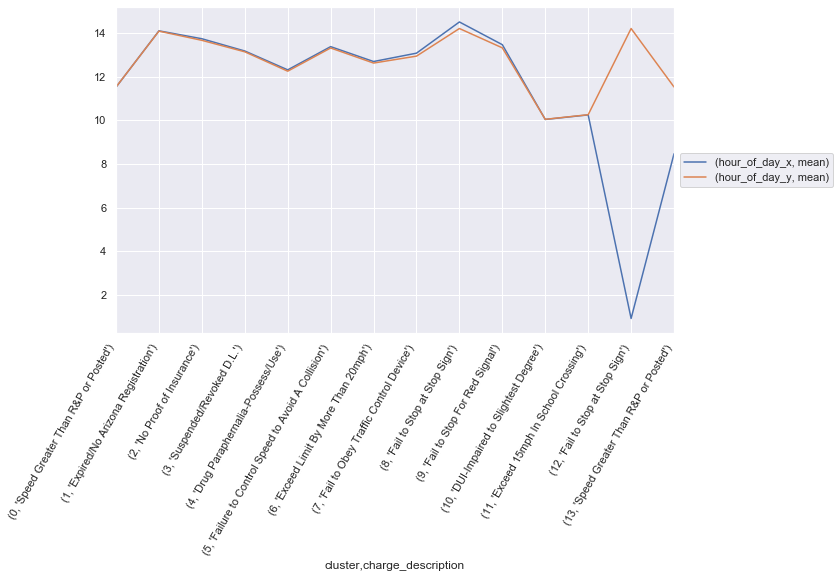

In [48]:
# fig, plt.subplots(figsize=(12, 6))

fig, ax = plt.subplots(figsize=(10, 6))

df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['hour_of_day']].reset_index().merge(
df.groupby(['charge_description']).agg(['mean']).loc[:,['hour_of_day']].reset_index(),
how='left',
on='charge_description').set_index(['cluster', 'charge_description']).plot(ax=ax)

plt.legend(loc='center left', bbox_to_anchor=(1.0, .5))


ax.set_xticks(range(0, len(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['hour_of_day']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['hour_of_day']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

ax.set_xticklabels(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,['hour_of_day']].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,['hour_of_day']],
    how='left',
    on='charge_description').set_index(['cluster', 'charge_description']).index))

plt.xticks(rotation=60, horizontalalignment="right");

## Examine Clusters Visually

### PCA

In [38]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

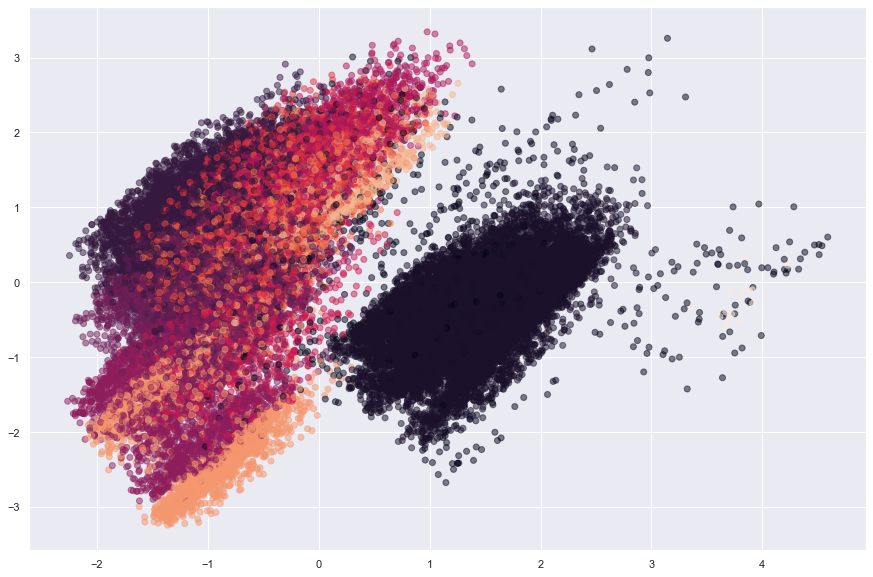

In [39]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [40]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 38417 samples in 0.814s...
[t-SNE] Computed neighbors for 38417 samples in 38.680s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38417
[t-SNE] Computed conditional probabilities for sample 2000 / 38417
[t-SNE] Computed conditional probabilities for sample 3000 / 38417
[t-SNE] Computed conditional probabilities for sample 4000 / 38417
[t-SNE] Computed conditional probabilities for sample 5000 / 38417
[t-SNE] Computed conditional probabilities for sample 6000 / 38417
[t-SNE] Computed conditional probabilities for sample 7000 / 38417
[t-SNE] Computed conditional probabilities for sample 8000 / 38417
[t-SNE] Computed conditional probabilities for sample 9000 / 38417
[t-SNE] Computed conditional probabilities for sample 10000 / 38417
[t-SNE] Computed conditional probabilities for sample 11000 / 38417
[t-SNE] Computed conditional probabilities for sample 12000 / 38417
[t-SNE] Computed conditional probabilities for s

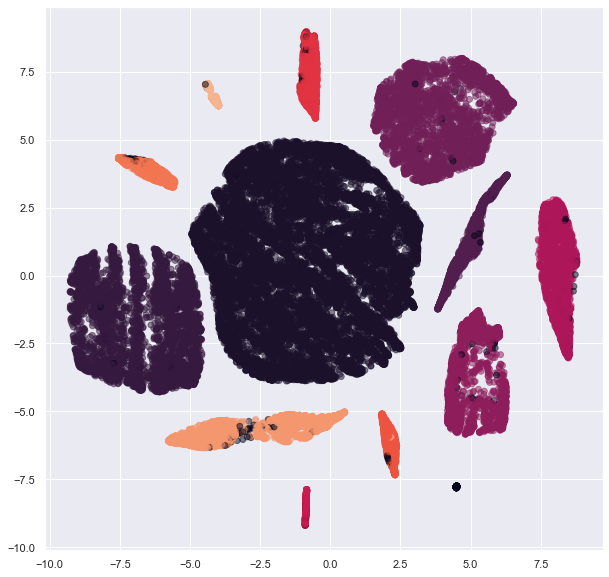

In [41]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [42]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

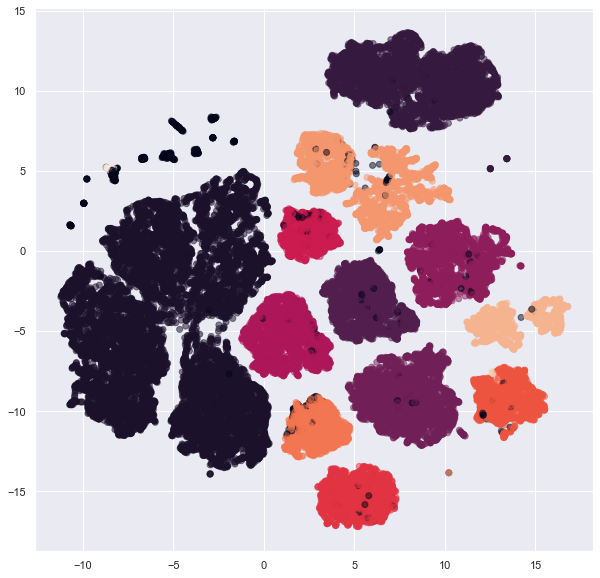

In [43]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));